In [29]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
def load_data_from_csv(file):
    df = pd.read_csv(file)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    df['cik'] = df['cik'].apply(lambda x: '0' * (10 - len(str(x))) + str(x))
    df['transaction_month'] = pd.to_datetime(df['transaction_month'])
    df = df.sort_values(['cik', 'transaction_month'])

    return df


def _add_signficance_level_sign(value, p_value, statistic=None):
    s = str(round(value, 3))
    
    if statistic:
        s += f" ({round(statistic, 3)})"
    
    if p_value <= 0.01:
        s += "***"
    elif p_value <= 0.05:
        s += "**"
    elif p_value <= 0.1:
        s += "*"
        
    return s


def _make_regression_table_for_aggregated_granger(gc_res):
    df = pd.DataFrame()
    i = 0
    for key, value in gc_res.items():
        params_ftest = value[0]['params_ftest']
        params = value[1][1].params
        pvalues = value[1][1].pvalues
        tvalues = value[1][1].tvalues
        df = pd.concat([
                df,
                pd.DataFrame(
                    {
                        'Длина лага': [key],
                        'Лаг': [1],
                        'β коэффициент при объясняющей переменной (t-статистика)': [_add_signficance_level_sign(params[key], pvalues[key], tvalues[key])],
                        'F-статистика': [_add_signficance_level_sign(params_ftest[0], params_ftest[1])]
                    }
                )])
        lag = []
        beta = []
        for i in range(key+1, len(params)-1):
            lag.append(i-key+1)
            beta.append(_add_signficance_level_sign(params[i], pvalues[i], tvalues[i]))
    
        df = pd.concat([
                df,
                pd.DataFrame(
                    {
                        'Лаг': lag,
                    'β коэффициент при объясняющей переменной (t-статистика)': beta
                }
            )])

    return df


def _adf_test(df, columns=None, return_p_value=False):
    d = {}
    if not columns:
        columns = df.columns
    for col in columns:
        p_value = adfuller(df[col])[1]
        print(col, 'Augmented Dickey-Fuller p-value: ', p_value)
        d[col] = p_value
    if return_p_value:
        return d
    


def _plot_series(df):
    ax = sns.lineplot(df.loc[:, ['NNI', 'NSI', 'PNI', 'SNI']])
    ax.set(xlabel='Месяц')
    plt.show()

    ax = sns.lineplot(df.loc[:, ['trt1m']])
    ax.set(xlabel='Месяц', ylabel='Полная месячная доходность, %')
    plt.show()


def _make_series_percent_change(df, columns):
    for col in columns:
        df[col] = df[col].pct_change() * 100

    return df.iloc[1::]


def _test_gc_for_size_groups(df, size, y='trt1m', x='NNI', make_stationar=True):
    df = df.merge(size, on=['cik', 'transaction_month'], how='inner')
    print(f"Full sample size: {df.shape[0]}")

    gc_res = {}
    
    for size_value in ['Large', 'Medium', 'Small', 'Micro']:
        if not size_value in df['size'].unique():
            continue
        print(f"{size_value}")
        agg_size_df = df.loc[df['size'] == size_value].groupby('transaction_month')[
            ['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']
        ].mean()
        
        p_value = _adf_test(agg_size_df, return_p_value=True)
        if make_stationar:
            cols_to_make_stationar = []
            for k, v in p_value.items():
                if v > 0.1:
                    cols_to_make_stationar.append(k)
            if len(cols_to_make_stationar) > 0:
                agg_size_df = _make_series_percent_change(agg_size_df, cols_to_make_stationar)
                _adf_test(agg_size_df, return_p_value=True)

        size_gc_res = _make_regression_table_for_aggregated_granger(
            grangercausalitytests(
                x=agg_size_df.loc[:, [y, x]],
                maxlag=[1, 3, 12],
                addconst=True
            )
        )

        gc_res[size_value] = size_gc_res

    return gc_res


In [31]:
size = load_data_from_csv('size.csv')

In [33]:
size.head()

,cik,transaction_month,size
2407360,0000000020,2003-12-31,Micro
2401824,0000000020,2004-01-31,Micro
2393151,0000000020,2004-02-29,Micro
2380468,0000000020,2004-03-31,Micro
2372477,0000000020,2004-04-30,Micro


### Officers only sample

In [54]:
officer = load_data_from_csv('officer.csv')
agg_officer = officer.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI',	'trt1m']].mean()

In [66]:
officer.head()

,cik,transaction_month,P,PV,S,SV,NNI,NSI,PNI,SNI,trt1m
0,0000001750,2004-07-31,3.0,13600.0,0.0,0.0,1.0,1.0,1.0,0.0,-8.370044
36706,0000001750,2004-12-31,0.0,0.0,30.0,36800.0,-1.0,-1.0,0.0,1.0,-0.365764
36707,0000001750,2005-01-31,0.0,0.0,11.0,27100.0,-1.0,-1.0,0.0,1.0,-14.464023
36708,0000001750,2005-03-31,0.0,0.0,7.0,69470.0,-1.0,-1.0,0.0,1.0,21.973094
1,0000001750,2005-10-31,1.0,6000.0,0.0,0.0,1.0,1.0,1.0,0.0,-7.275902


In [67]:
agg_officer.head()

,NNI,NSI,PNI,SNI,trt1m
transaction_month,,,,,
2004-01-31,-0.734202,-0.754898,0.132899,0.867101,6.406702
2004-02-29,-0.769313,-0.783870,0.115344,0.884656,2.083074
2004-03-31,-0.753586,-0.763657,0.123207,0.876793,1.808186
2004-04-30,-0.710002,-0.715797,0.144999,0.855001,-2.646511
2004-05-31,-0.541639,-0.558667,0.229180,0.770820,2.341101


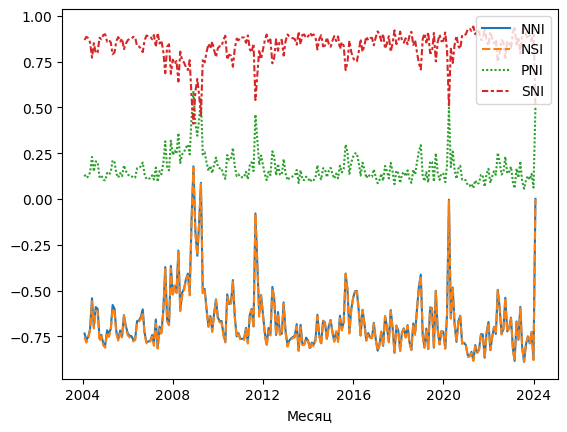

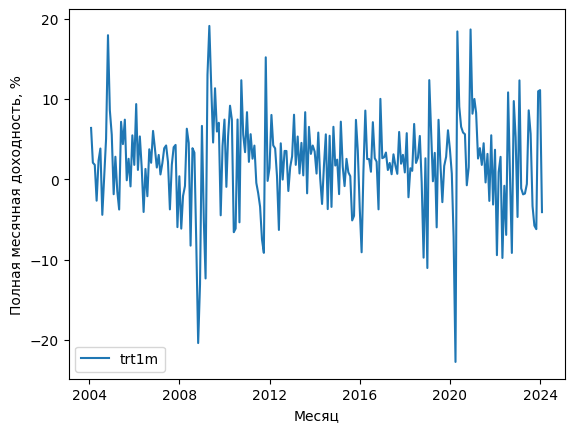

In [55]:
_plot_series(agg_officer)

In [56]:
gc_res = _test_gc_for_size_groups(officer, size, make_stationar=False)

Full sample size: 201431
Large
NNI Augmented Dickey-Fuller p-value:  0.09499850478804445
NSI Augmented Dickey-Fuller p-value:  0.08113652973780905
PNI Augmented Dickey-Fuller p-value:  0.09499850478804361
SNI Augmented Dickey-Fuller p-value:  0.09499850478804434
trt1m Augmented Dickey-Fuller p-value:  1.2270518153433037e-27

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0095  , p=0.9226  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.0096  , p=0.9220  , df=1
likelihood ratio test: chi2=0.0096  , p=0.9220  , df=1
parameter F test:         F=0.0095  , p=0.9226  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7463  , p=0.0437  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=8.4897  , p=0.0369  , df=3
likelihood ratio test: chi2=8.3412  , p=0.0395  , df=3
parameter F test:         F=2.7463  , p=0.0437  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:      

In [82]:
gc_res['Large']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,-1.049 (-0.381),0.145
0,3.0,1.0,-1.774 (-0.457),2.512*
0,NaN,2.0,9.056 (2.417)**,NaN
1,NaN,3.0,-7.055 (-2.058)**,NaN
0,12.0,1.0,-2.428 (-0.532),2.063**
0,NaN,2.0,7.622 (1.681)*,NaN
1,NaN,3.0,-14.493 (-3.148)***,NaN
2,NaN,4.0,-6.09 (-1.246),NaN
3,NaN,5.0,-1.211 (-0.248),NaN
4,NaN,6.0,5.882 (1.21),NaN


In [83]:
gc_res['Medium']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,4.09 (1.526),2.329
0,3.0,1.0,4.475 (1.23),3.711**
0,NaN,2.0,8.942 (2.575)**,NaN
1,NaN,3.0,-8.307 (-2.598)***,NaN
0,12.0,1.0,4.386 (1.006),1.694*
0,NaN,2.0,5.694 (1.318),NaN
1,NaN,3.0,-10.913 (-2.487)**,NaN
2,NaN,4.0,3.265 (0.713),NaN
3,NaN,5.0,6.974 (1.534),NaN
4,NaN,6.0,-0.281 (-0.062),NaN


In [84]:
gc_res['Small']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,2.908 (1.178),1.387
0,3.0,1.0,1.265 (0.341),1.952
0,NaN,2.0,7.874 (2.171)**,NaN
1,NaN,3.0,-4.553 (-1.351),NaN
0,12.0,1.0,1.499 (0.309),1.064
0,NaN,2.0,9.202 (1.911)*,NaN
1,NaN,3.0,-4.159 (-0.818),NaN
2,NaN,4.0,4.522 (0.865),NaN
3,NaN,5.0,-2.368 (-0.453),NaN
4,NaN,6.0,-3.585 (-0.683),NaN


In [85]:
gc_res['Micro']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,1.732 (0.599),0.359
0,3.0,1.0,-0.844 (-0.211),0.898
0,NaN,2.0,2.247 (0.554),NaN
1,NaN,3.0,3.723 (0.943),NaN
0,12.0,1.0,7.135 (1.751)*,1.932**
0,NaN,2.0,-4.462 (-1.066),NaN
1,NaN,3.0,2.721 (0.667),NaN
2,NaN,4.0,-5.16 (-1.246),NaN
3,NaN,5.0,-3.572 (-0.864),NaN
4,NaN,6.0,3.76 (0.913),NaN


In [110]:
officer_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_officer.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5954  , p=0.1085  , df_denom=237, df_num=1
ssr based chi2 test:   chi2=2.6283  , p=0.1050  , df=1
likelihood ratio test: chi2=2.6140  , p=0.1059  , df=1
parameter F test:         F=2.5954  , p=0.1085  , df_denom=237, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6507  , p=0.0495  , df_denom=231, df_num=3
ssr based chi2 test:   chi2=8.1930  , p=0.0422  , df=3
likelihood ratio test: chi2=8.0551  , p=0.0449  , df=3
parameter F test:         F=2.6507  , p=0.0495  , df_denom=231, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.3693  , p=0.1828  , df_denom=204, df_num=12
ssr based chi2 test:   chi2=18.4458 , p=0.1028  , df=12
likelihood ratio test: chi2=17.7406 , p=0.1238  , df=12
parameter F test:         F=1.3693  , p=0.1828  , df_denom=204, df_num=12


In [111]:
officer_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,4.204 (1.611),2.595
0,3.0,1.0,4.149 (1.062),2.651**
0,NaN,2.0,8.097 (2.153)**,NaN
1,NaN,3.0,-6.116 (-1.703)*,NaN
0,12.0,1.0,2.829 (0.563),1.369
0,NaN,2.0,6.443 (1.322),NaN
1,NaN,3.0,-7.461 (-1.506),NaN
2,NaN,4.0,2.926 (0.549),NaN
3,NaN,5.0,1.059 (0.199),NaN
4,NaN,6.0,0.3 (0.057),NaN


### Officers and directors sample

In [75]:
officer_director = load_data_from_csv('officer_director.csv')
agg_officer_director = officer_director.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

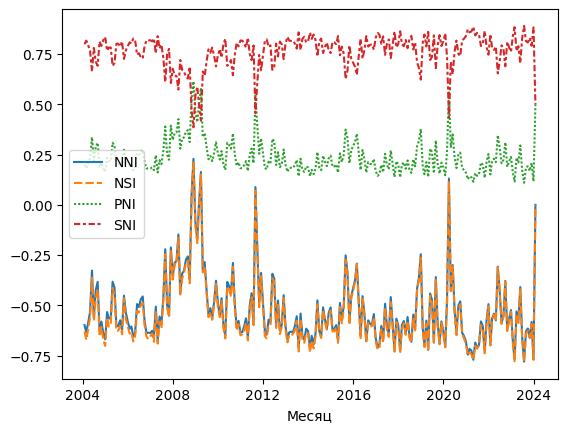

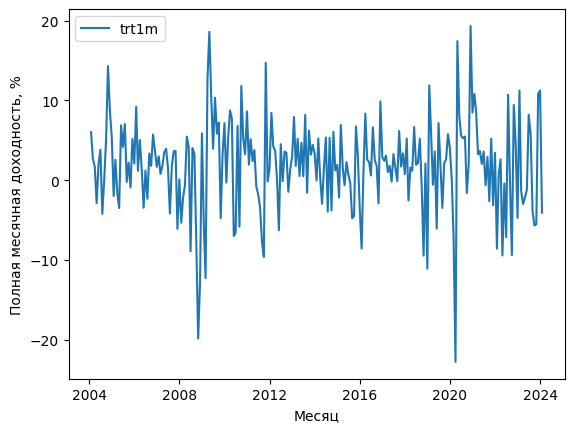

In [21]:
_plot_series(agg_officer_director)

In [86]:
gc_res = _test_gc_for_size_groups(officer_director, size, make_stationar=False)

Full sample size: 263946
Large
NNI Augmented Dickey-Fuller p-value:  0.00028808608946819664
NSI Augmented Dickey-Fuller p-value:  0.00022088714506148584
PNI Augmented Dickey-Fuller p-value:  0.00028808608946820927
SNI Augmented Dickey-Fuller p-value:  0.0002880860894682207
trt1m Augmented Dickey-Fuller p-value:  1.930979545304596e-09

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1453  , p=0.7034  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.1472  , p=0.7012  , df=1
likelihood ratio test: chi2=0.1471  , p=0.7013  , df=1
parameter F test:         F=0.1453  , p=0.7034  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5122  , p=0.0593  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=7.7659  , p=0.0511  , df=3
likelihood ratio test: chi2=7.6414  , p=0.0540  , df=3
parameter F test:         F=2.5122  , p=0.0593  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F t

In [88]:
gc_res['Large']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,-1.049 (-0.381),0.145
0,3.0,1.0,-1.774 (-0.457),2.512*
0,NaN,2.0,9.056 (2.417)**,NaN
1,NaN,3.0,-7.055 (-2.058)**,NaN
0,12.0,1.0,-2.428 (-0.532),2.063**
0,NaN,2.0,7.622 (1.681)*,NaN
1,NaN,3.0,-14.493 (-3.148)***,NaN
2,NaN,4.0,-6.09 (-1.246),NaN
3,NaN,5.0,-1.211 (-0.248),NaN
4,NaN,6.0,5.882 (1.21),NaN


In [87]:
gc_res['Medium']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,4.09 (1.526),2.329
0,3.0,1.0,4.475 (1.23),3.711**
0,NaN,2.0,8.942 (2.575)**,NaN
1,NaN,3.0,-8.307 (-2.598)***,NaN
0,12.0,1.0,4.386 (1.006),1.694*
0,NaN,2.0,5.694 (1.318),NaN
1,NaN,3.0,-10.913 (-2.487)**,NaN
2,NaN,4.0,3.265 (0.713),NaN
3,NaN,5.0,6.974 (1.534),NaN
4,NaN,6.0,-0.281 (-0.062),NaN


In [89]:
gc_res['Small']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,2.908 (1.178),1.387
0,3.0,1.0,1.265 (0.341),1.952
0,NaN,2.0,7.874 (2.171)**,NaN
1,NaN,3.0,-4.553 (-1.351),NaN
0,12.0,1.0,1.499 (0.309),1.064
0,NaN,2.0,9.202 (1.911)*,NaN
1,NaN,3.0,-4.159 (-0.818),NaN
2,NaN,4.0,4.522 (0.865),NaN
3,NaN,5.0,-2.368 (-0.453),NaN
4,NaN,6.0,-3.585 (-0.683),NaN


In [90]:
gc_res['Micro']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,1.732 (0.599),0.359
0,3.0,1.0,-0.844 (-0.211),0.898
0,NaN,2.0,2.247 (0.554),NaN
1,NaN,3.0,3.723 (0.943),NaN
0,12.0,1.0,7.135 (1.751)*,1.932**
0,NaN,2.0,-4.462 (-1.066),NaN
1,NaN,3.0,2.721 (0.667),NaN
2,NaN,4.0,-5.16 (-1.246),NaN
3,NaN,5.0,-3.572 (-0.864),NaN
4,NaN,6.0,3.76 (0.913),NaN


In [108]:
officer_director_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_officer_director.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5116  , p=0.1143  , df_denom=237, df_num=1
ssr based chi2 test:   chi2=2.5434  , p=0.1108  , df=1
likelihood ratio test: chi2=2.5300  , p=0.1117  , df=1
parameter F test:         F=2.5116  , p=0.1143  , df_denom=237, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7395  , p=0.0441  , df_denom=231, df_num=3
ssr based chi2 test:   chi2=8.4675  , p=0.0373  , df=3
likelihood ratio test: chi2=8.3204  , p=0.0398  , df=3
parameter F test:         F=2.7395  , p=0.0441  , df_denom=231, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2000  , p=0.2849  , df_denom=204, df_num=12
ssr based chi2 test:   chi2=16.1652 , p=0.1838  , df=12
likelihood ratio test: chi2=15.6201 , p=0.2093  , df=12
parameter F test:         F=1.2000  , p=0.2849  , df_denom=204, df_num=12


In [109]:
officer_director_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,3.903 (1.585),2.512
0,3.0,1.0,3.498 (0.959),2.739**
0,NaN,2.0,7.968 (2.256)**,NaN
1,NaN,3.0,-5.318 (-1.587),NaN
0,12.0,1.0,4.592 (0.943),1.2
0,NaN,2.0,7.597 (1.587),NaN
1,NaN,3.0,-6.248 (-1.277),NaN
2,NaN,4.0,0.201 (0.039),NaN
3,NaN,5.0,-2.022 (-0.389),NaN
4,NaN,6.0,0.157 (0.03),NaN


### Directors only sample

In [61]:
director = load_data_from_csv('director.csv')
agg_director = director.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

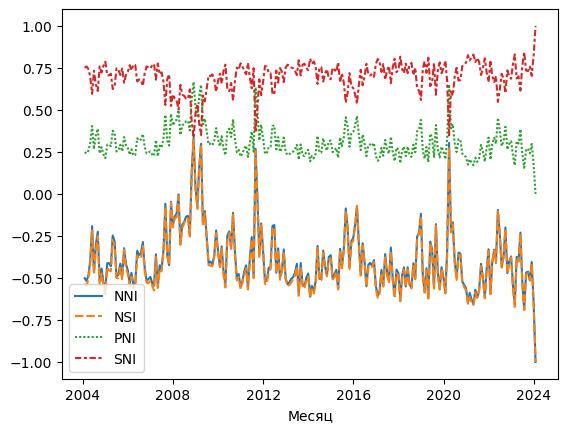

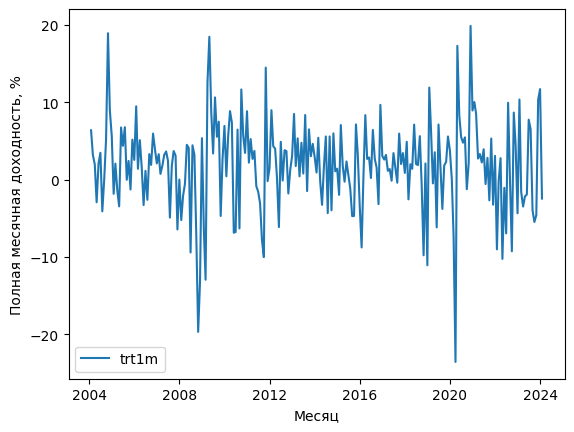

In [92]:
_plot_series(agg_director)

In [91]:
gc_res = _test_gc_for_size_groups(director, size, make_stationar=False)

Full sample size: 184056
Large
NNI Augmented Dickey-Fuller p-value:  0.10797592576778503
NSI Augmented Dickey-Fuller p-value:  0.11195794805364656
PNI Augmented Dickey-Fuller p-value:  0.10797592576778486
SNI Augmented Dickey-Fuller p-value:  0.10797592576778514
trt1m Augmented Dickey-Fuller p-value:  5.58299409562623e-09

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5255  , p=0.4692  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.5321  , p=0.4657  , df=1
likelihood ratio test: chi2=0.5315  , p=0.4660  , df=1
parameter F test:         F=0.5255  , p=0.4692  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1777  , p=0.3190  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=3.6407  , p=0.3030  , df=3
likelihood ratio test: chi2=3.6130  , p=0.3064  , df=3
parameter F test:         F=1.1777  , p=0.3190  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:        

In [93]:
gc_res['Large']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,-1.68 (-0.725),0.525
0,3.0,1.0,-2.294 (-0.743),1.178
0,NaN,2.0,4.963 (1.672)*,NaN
1,NaN,3.0,-2.932 (-1.069),NaN
0,12.0,1.0,-2.106 (-0.556),1.505
0,NaN,2.0,4.299 (1.16),NaN
1,NaN,3.0,-7.31 (-1.956)*,NaN
2,NaN,4.0,-2.565 (-0.674),NaN
3,NaN,5.0,-2.215 (-0.584),NaN
4,NaN,6.0,1.832 (0.486),NaN


In [94]:
gc_res['Medium']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,3.335 (1.438),2.067
0,3.0,1.0,3.027 (0.986),3.296**
0,NaN,2.0,7.534 (2.528)**,NaN
1,NaN,3.0,-6.377 (-2.335)**,NaN
0,12.0,1.0,2.857 (0.784),1.477
0,NaN,2.0,5.811 (1.605),NaN
1,NaN,3.0,-7.242 (-1.981)**,NaN
2,NaN,4.0,5.671 (1.5),NaN
3,NaN,5.0,4.183 (1.107),NaN
4,NaN,6.0,-1.638 (-0.432),NaN


In [95]:
gc_res['Small']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,2.498 (1.088),1.183
0,3.0,1.0,1.471 (0.446),2.322*
0,NaN,2.0,7.623 (2.373)**,NaN
1,NaN,3.0,-4.528 (-1.521),NaN
0,12.0,1.0,0.461 (0.109),1.173
0,NaN,2.0,9.991 (2.355)**,NaN
1,NaN,3.0,-4.157 (-0.929),NaN
2,NaN,4.0,3.985 (0.877),NaN
3,NaN,5.0,-5.063 (-1.111),NaN
4,NaN,6.0,-1.358 (-0.297),NaN


In [96]:
gc_res['Micro']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,1.524 (0.479),0.23
0,3.0,1.0,0.579 (0.139),0.458
0,NaN,2.0,0.782 (0.182),NaN
1,NaN,3.0,2.996 (0.745),NaN
0,12.0,1.0,7.373 (1.931)*,1.885**
0,NaN,2.0,-6.044 (-1.517),NaN
1,NaN,3.0,4.781 (1.266),NaN
2,NaN,4.0,-7.839 (-2.025)**,NaN
3,NaN,5.0,-1.408 (-0.361),NaN
4,NaN,6.0,2.785 (0.704),NaN


In [106]:
director_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_director.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0851  , p=0.1501  , df_denom=237, df_num=1
ssr based chi2 test:   chi2=2.1115  , p=0.1462  , df=1
likelihood ratio test: chi2=2.1023  , p=0.1471  , df=1
parameter F test:         F=2.0851  , p=0.1501  , df_denom=237, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1536  , p=0.0943  , df_denom=231, df_num=3
ssr based chi2 test:   chi2=6.6566  , p=0.0837  , df=3
likelihood ratio test: chi2=6.5652  , p=0.0871  , df=3
parameter F test:         F=2.1536  , p=0.0943  , df_denom=231, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.0854  , p=0.3740  , df_denom=204, df_num=12
ssr based chi2 test:   chi2=14.6204 , p=0.2629  , df=12
likelihood ratio test: chi2=14.1726 , p=0.2898  , df=12
parameter F test:         F=1.0854  , p=0.3740  , df_denom=204, df_num=12


In [107]:
director_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,3.366 (1.444),2.085
0,3.0,1.0,2.938 (0.885),2.154*
0,NaN,2.0,6.497 (2.015)**,NaN
1,NaN,3.0,-3.879 (-1.285),NaN
0,12.0,1.0,2.989 (0.678),1.085
0,NaN,2.0,6.816 (1.573),NaN
1,NaN,3.0,-3.415 (-0.776),NaN
2,NaN,4.0,1.154 (0.251),NaN
3,NaN,5.0,-3.903 (-0.844),NaN
4,NaN,6.0,-0.872 (-0.189),NaN


### Owners only sample

In [97]:
owner = load_data_from_csv('owner.csv')
agg_owner = owner.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

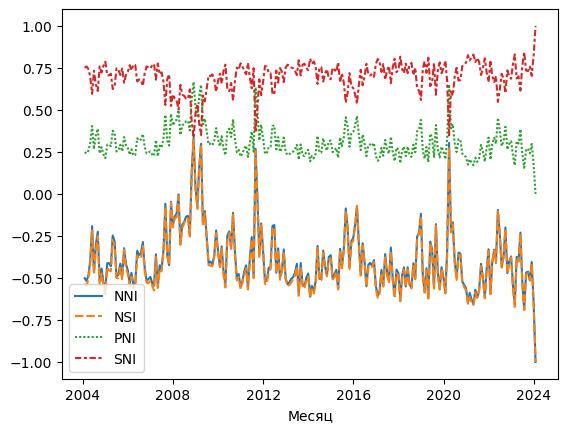

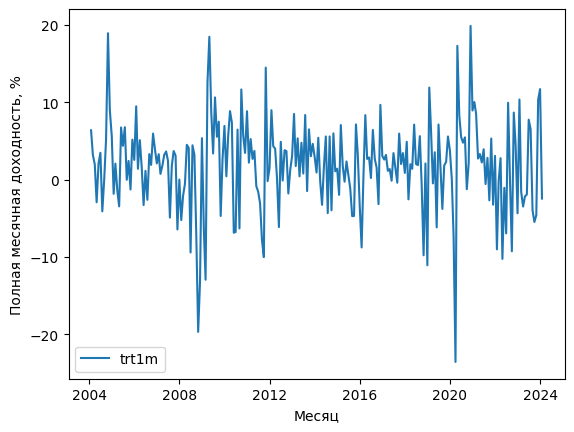

In [98]:
_plot_series(agg_director)

In [99]:
gc_res = _test_gc_for_size_groups(owner, size, make_stationar=False)

Full sample size: 37991
Large
NNI Augmented Dickey-Fuller p-value:  5.6559163174043245e-06
NSI Augmented Dickey-Fuller p-value:  6.417752228452245e-06
PNI Augmented Dickey-Fuller p-value:  5.655916317404419e-06
SNI Augmented Dickey-Fuller p-value:  5.655916317404523e-06
trt1m Augmented Dickey-Fuller p-value:  9.8319439888251e-26

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0451  , p=0.8319  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.0457  , p=0.8307  , df=1
likelihood ratio test: chi2=0.0457  , p=0.8307  , df=1
parameter F test:         F=0.0451  , p=0.8319  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3377  , p=0.7981  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=1.0440  , p=0.7906  , df=3
likelihood ratio test: chi2=1.0417  , p=0.7912  , df=3
parameter F test:         F=0.3377  , p=0.7981  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test: 

In [100]:
gc_res['Large']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,-0.323 (-0.212),0.045
0,3.0,1.0,-1.018 (-0.552),0.338
0,NaN,2.0,0.562 (0.29),NaN
1,NaN,3.0,1.359 (0.764),NaN
0,12.0,1.0,-2.272 (-1.089),0.8
0,NaN,2.0,0.694 (0.324),NaN
1,NaN,3.0,0.827 (0.392),NaN
2,NaN,4.0,1.391 (0.654),NaN
3,NaN,5.0,0.864 (0.406),NaN
4,NaN,6.0,0.634 (0.297),NaN


In [101]:
gc_res['Medium']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,1.302 (0.783),0.613
0,3.0,1.0,0.121 (0.059),2.078
0,NaN,2.0,4.264 (1.957)*,NaN
1,NaN,3.0,-4.352 (-2.196)**,NaN
0,12.0,1.0,-0.11 (-0.046),0.861
0,NaN,2.0,4.823 (1.959)*,NaN
1,NaN,3.0,-3.919 (-1.582),NaN
2,NaN,4.0,0.336 (0.135),NaN
3,NaN,5.0,-4.971 (-2.014)**,NaN
4,NaN,6.0,0.657 (0.264),NaN


In [102]:
gc_res['Small']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,1.261 (0.593),0.352
0,3.0,1.0,1.821 (0.571),0.655
0,NaN,2.0,3.258 (1.023),NaN
1,NaN,3.0,-2.795 (-0.994),NaN
0,12.0,1.0,2.622 (0.73),1.437
0,NaN,2.0,7.298 (1.951)*,NaN
1,NaN,3.0,-0.88 (-0.231),NaN
2,NaN,4.0,3.815 (1.004),NaN
3,NaN,5.0,-3.418 (-0.9),NaN
4,NaN,6.0,-5.632 (-1.473),NaN


In [103]:
gc_res['Micro']

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,2.909 (1.16),1.346
0,3.0,1.0,4.684 (1.416),1.408
0,NaN,2.0,2.645 (0.731),NaN
1,NaN,3.0,-3.716 (-1.169),NaN
0,12.0,1.0,6.454 (1.694)*,1.175
0,NaN,2.0,1.278 (0.305),NaN
1,NaN,3.0,-4.817 (-1.178),NaN
2,NaN,4.0,-1.107 (-0.264),NaN
3,NaN,5.0,-4.82 (-1.155),NaN
4,NaN,6.0,10.788 (2.596)**,NaN


In [104]:
owner_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_owner.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1907  , p=0.2763  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=1.2058  , p=0.2722  , df=1
likelihood ratio test: chi2=1.2028  , p=0.2728  , df=1
parameter F test:         F=1.1907  , p=0.2763  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0633  , p=0.1059  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=6.3782  , p=0.0946  , df=3
likelihood ratio test: chi2=6.2939  , p=0.0982  , df=3
parameter F test:         F=2.0633  , p=0.1059  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.4154  , p=0.1609  , df_denom=203, df_num=12
ssr based chi2 test:   chi2=19.0769 , p=0.0867  , df=12
likelihood ratio test: chi2=18.3207 , p=0.1063  , df=12
parameter F test:         F=1.4154  , p=0.1609  , df_denom=203, df_num=12


In [105]:
owner_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,2.44 (1.091),1.191
0,3.0,1.0,4.913 (1.284),2.063
0,NaN,2.0,5.568 (1.389),NaN
1,NaN,3.0,-6.813 (-1.965)*,NaN
0,12.0,1.0,5.02 (1.186),1.415
0,NaN,2.0,9.564 (2.095)**,NaN
1,NaN,3.0,-5.309 (-1.135),NaN
2,NaN,4.0,-0.327 (-0.07),NaN
3,NaN,5.0,-5.492 (-1.179),NaN
4,NaN,6.0,2.24 (0.483),NaN


## Size analyses

In [32]:
all = load_data_from_csv('granger.csv')

In [ ]:
# all 278780 rows, with sizes 278566

In [33]:
all = all.merge(size, on=['cik', 'transaction_month'], how='inner')

In [40]:
all['size'].value_counts()

size
Small     104480
Large      65957
Medium     62056
Micro      46073
Name: count, dtype: int64

### Large

In [34]:
large = all.loc[all['size'] == 'Large']

In [35]:
agg_large = large.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

In [41]:
large_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_large.loc[:, ['trt1m', 'PNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1110  , p=0.7393  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.1124  , p=0.7374  , df=1
likelihood ratio test: chi2=0.1124  , p=0.7374  , df=1
parameter F test:         F=0.1110  , p=0.7393  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1713  , p=0.0922  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=6.7123  , p=0.0817  , df=3
likelihood ratio test: chi2=6.6190  , p=0.0851  , df=3
parameter F test:         F=2.1713  , p=0.0922  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.8597  , p=0.0412  , df_denom=203, df_num=12
ssr based chi2 test:   chi2=25.0647 , p=0.0145  , df=12
likelihood ratio test: chi2=23.7803 , p=0.0218  , df=12
parameter F test:         F=1.8597  , p=0.0412  , df_denom=203, df_num=12


In [42]:
large_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,-1.808 (-0.333),0.111
0,3.0,1.0,-2.388 (-0.3),2.171*
0,NaN,2.0,16.918 (2.252)**,NaN
1,NaN,3.0,-13.473 (-1.941)*,NaN
0,12.0,1.0,-2.766 (-0.3),1.86**
0,NaN,2.0,16.331 (1.798)*,NaN
1,NaN,3.0,-25.001 (-2.692)***,NaN
2,NaN,4.0,-10.647 (-1.097),NaN
3,NaN,5.0,1.16 (0.12),NaN
4,NaN,6.0,6.688 (0.696),NaN


### Medium

In [112]:
medium = all.loc[all['size'] == 'Medium']

In [113]:
agg_medium = medium.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

In [114]:
medium_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_medium.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3713  , p=0.1249  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=2.4015  , p=0.1212  , df=1
likelihood ratio test: chi2=2.3895  , p=0.1222  , df=1
parameter F test:         F=2.3713  , p=0.1249  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0377  , p=0.0080  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=12.4818 , p=0.0059  , df=3
likelihood ratio test: chi2=12.1642 , p=0.0068  , df=3
parameter F test:         F=4.0377  , p=0.0080  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.7466  , p=0.0594  , df_denom=203, df_num=12
ssr based chi2 test:   chi2=23.5408 , p=0.0235  , df=12
likelihood ratio test: chi2=22.4032 , p=0.0332  , df=12
parameter F test:         F=1.7466  , p=0.0594  , df_denom=203, df_num=12


In [115]:
medium_res


,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,4.202 (1.54),2.371
0,3.0,1.0,4.593 (1.204),4.038***
0,NaN,2.0,10.067 (2.788)***,NaN
1,NaN,3.0,-8.838 (-2.654)***,NaN
0,12.0,1.0,5.13 (1.123),1.747*
0,NaN,2.0,7.847 (1.744)*,NaN
1,NaN,3.0,-10.753 (-2.334)**,NaN
2,NaN,4.0,2.396 (0.5),NaN
3,NaN,5.0,5.634 (1.187),NaN
4,NaN,6.0,-2.481 (-0.521),NaN


### Small

In [116]:
small = all.loc[all['size'] == 'Small']

In [117]:
agg_small = small.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

In [118]:
small_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_small.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7094  , p=0.1923  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=1.7311  , p=0.1883  , df=1
likelihood ratio test: chi2=1.7248  , p=0.1891  , df=1
parameter F test:         F=1.7094  , p=0.1923  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1768  , p=0.0915  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=6.7291  , p=0.0811  , df=3
likelihood ratio test: chi2=6.6353  , p=0.0845  , df=3
parameter F test:         F=2.1768  , p=0.0915  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.1505  , p=0.3214  , df_denom=203, df_num=12
ssr based chi2 test:   chi2=15.5067 , p=0.2149  , df=12
likelihood ratio test: chi2=15.0022 , p=0.2413  , df=12
parameter F test:         F=1.1505  , p=0.3214  , df_denom=203, df_num=12


In [119]:
small_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,3.238 (1.307),1.709
0,3.0,1.0,2.272 (0.575),2.177*
0,NaN,2.0,8.356 (2.177)**,NaN
1,NaN,3.0,-5.667 (-1.598),NaN
0,12.0,1.0,3.485 (0.705),1.151
0,NaN,2.0,10.072 (2.054)**,NaN
1,NaN,3.0,-5.036 (-0.965),NaN
2,NaN,4.0,2.935 (0.55),NaN
3,NaN,5.0,-1.73 (-0.323),NaN
4,NaN,6.0,-3.577 (-0.666),NaN


### Micro

In [75]:
micro = all.loc[all['size'] == 'Micro']

In [76]:
agg_micro = micro.groupby('transaction_month')[['NNI', 'NSI', 'PNI', 'SNI', 'trt1m']].mean()

In [78]:
micro_res = _make_regression_table_for_aggregated_granger(
    grangercausalitytests(
        x=agg_small.loc[:, ['trt1m', 'NNI']],
        maxlag=[1, 3, 12],
        addconst=True
    )
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4177  , p=0.5187  , df_denom=235, df_num=1
ssr based chi2 test:   chi2=0.4230  , p=0.5154  , df=1
likelihood ratio test: chi2=0.4226  , p=0.5156  , df=1
parameter F test:         F=0.4177  , p=0.5187  , df_denom=235, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3102  , p=0.2718  , df_denom=229, df_num=3
ssr based chi2 test:   chi2=4.0506  , p=0.2561  , df=3
likelihood ratio test: chi2=4.0162  , p=0.2597  , df=3
parameter F test:         F=1.3102  , p=0.2718  , df_denom=229, df_num=3

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=3.6146  , p=0.0001  , df_denom=202, df_num=12
ssr based chi2 test:   chi2=48.7431 , p=0.0000  , df=12
likelihood ratio test: chi2=44.1559 , p=0.0000  , df=12
parameter F test:         F=3.6146  , p=0.0001  , df_denom=202, df_num=12


In [79]:
micro_res

,Длина лага,Лаг,β коэффициент при объясняющей переменной (t-статистика),F-статистика
0,1.0,1.0,-0.003 (-0.646),0.418
0,3.0,1.0,-0.002 (-0.388),1.31
0,NaN,2.0,-0.001 (-0.247),NaN
1,NaN,3.0,0.009 (1.879)*,NaN
0,12.0,1.0,-0.001 (-0.211),3.615***
0,NaN,2.0,-0.005 (-0.998),NaN
1,NaN,3.0,0.006 (1.282),NaN
2,NaN,4.0,-0.003 (-0.648),NaN
3,NaN,5.0,-0.012 (-2.468)**,NaN
4,NaN,6.0,-0.015 (-3.191)***,NaN
